In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from itertools import product

pd.set_option('display.max_columns', None)

In [ ]:
# this cell may take up to 30 seconds to run to convert the Hugginface Dataset class to Pandas DataFrame for better EDA

HF_SPOTIFY_DATASET_PATH = "maharshipandya/spotify-tracks-dataset"
# https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset

ds = load_dataset(HF_SPOTIFY_DATASET_PATH) #only has 'train' split as key
df = pd.DataFrame(ds["train"])

print(df.shape)
df.head()


(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
#analyzing features for ones most relevant to genre
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [ ]:
# goal is to predict the genre
y = df["track_genre"]

# we decided to drop text identifiers such as album, artist, etc. and consider the most relevant characteristics such as
# danceability, energy, loudness, etc. because genres may differ most in these categories
# ex: edm is high energy, lofi is low energy
relevant_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'valence', 'tempo', "popularity"
]

# Select only the relevant features
X = df[relevant_features]
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,popularity
0,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.7150,87.917,73
1,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.2670,77.489,55
2,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1200,76.332,57
3,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1430,181.740,71
4,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.1670,119.949,82
...,...,...,...,...,...,...,...,...,...
113995,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0339,125.995,21
113996,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.0350,85.239,22
113997,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.7430,132.378,22
113998,0.587,0.5060,-10.889,0.0297,0.3810,0.000000,0.4130,135.960,41


In [ ]:
# encode y strings into int

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = y_encoded
y

array([  0,   0,   0, ..., 113, 113, 113])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# divide into train (60%) and testval (40%)
X_train, X_testval, y_train, y_testval = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Second split: divide testval into val (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_testval, y_testval, test_size=0.5, random_state=42
)


# scale the data since they are on different scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Implementing a multi-layer perceptron

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# First convert your numpy data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

# Create dataset and dataloader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

In [ ]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize model, loss function, and optimizer
model = NeuralNetwork(num_features=X_train.shape[1], num_classes=len(np.unique(y_train)))
loss_fn  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#define train and test functions

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    total_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches
    correct /= size
    return total_loss, correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, correct

In [ ]:
# Training loop
epochs = 40
best_accuracy = 0
res = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Get training metrics
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Get validation metrics
    val_loss, val_acc = test(val_loader, model, loss_fn)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        res = val_loss

print("Done!")

print(f"best accuracy: {best_accuracy}, corresponding loss: {res}")

Epoch 1
-------------------------------
loss: 4.719295  [  100/68400]
loss: 3.663256  [20100/68400]
loss: 3.389813  [40100/68400]
loss: 3.369505  [60100/68400]
Test Error: 
 Accuracy: 18.7%, Avg loss: 3.323180
Epoch 2
-------------------------------
loss: 3.475512  [  100/68400]
loss: 3.267236  [20100/68400]
loss: 2.998113  [40100/68400]
loss: 3.129752  [60100/68400]
Test Error: 
 Accuracy: 21.0%, Avg loss: 3.182492
Epoch 3
-------------------------------
loss: 3.470340  [  100/68400]
loss: 3.025403  [20100/68400]
loss: 3.147364  [40100/68400]
loss: 2.962056  [60100/68400]
Test Error: 
 Accuracy: 22.1%, Avg loss: 3.116059
Epoch 4
-------------------------------
loss: 3.084549  [  100/68400]
loss: 3.215957  [20100/68400]
loss: 3.015383  [40100/68400]
loss: 2.804297  [60100/68400]
Test Error: 
 Accuracy: 22.8%, Avg loss: 3.056377
Epoch 5
-------------------------------
loss: 3.153821  [  100/68400]
loss: 3.203695  [20100/68400]
loss: 2.972870  [40100/68400]
loss: 2.977591  [60100/68400]


## Evaluating the neural network performance

In [ ]:
train_losses

[3.657876383491427,
 3.22810607486301,
 3.122075090631407,
 3.0549774086266233,
 3.0032669250030963,
 2.9622950818803577,
 2.9264742550794143,
 2.8965079014064274,
 2.8696608696764674,
 2.846344670008498,
 2.8250107329491287,
 2.8051161065436245,
 2.7895019524975826,
 2.775892980963166,
 2.759941430468308,
 2.7477455480754025,
 2.738574374837485,
 2.7277506572461268,
 2.7178819608270075,
 2.709427875733515,
 2.7001219329081083,
 2.693025190927829,
 2.6871558337183723,
 2.679373527479451,
 2.6728070270248323,
 2.6680325911059017,
 2.6619101180667766,
 2.655686697067573,
 2.652925138933617,
 2.646256133129722,
 2.6409670320170666,
 2.6384857516539726,
 2.634059680484192,
 2.628175681794596,
 2.6270600257561223,
 2.622897165212018,
 2.6198146991562425,
 2.61690772695151,
 2.612359737966493,
 2.611121383675358]

Text(0.5, 0, 'Epoch')

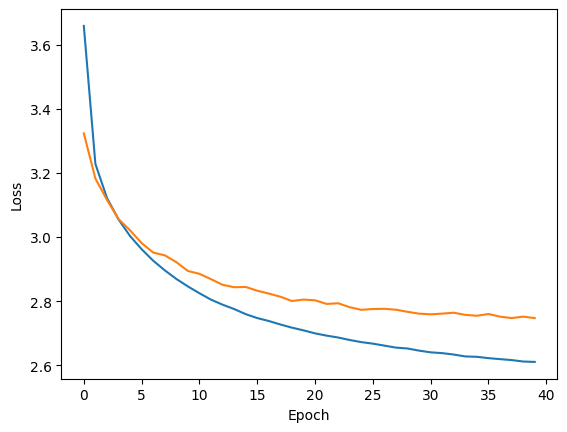

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label="training")
plt.plot(range(epochs), val_losses, label="Validation")
plt.ylabel('Loss')
plt.xlabel('Epoch')

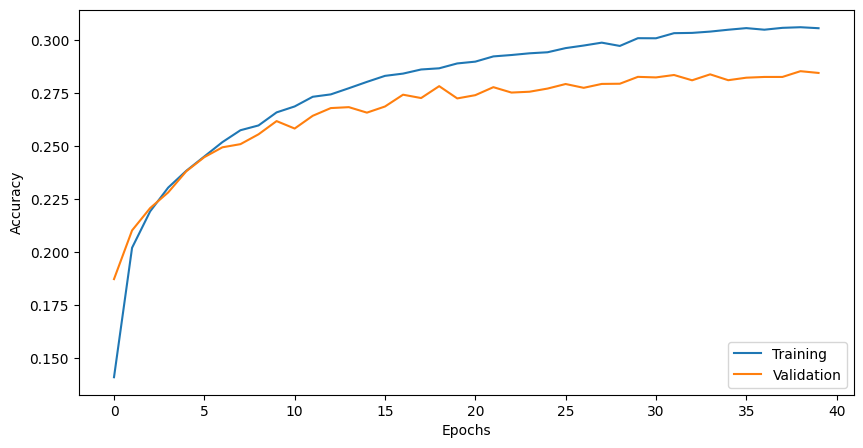

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_accuracies, label='Training')
plt.plot(range(epochs), val_accuracies, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

## QUESTION 2
2. Please explain the metrics you are using to assess the performance of your NN.

The metrics we used were cross entropy loss and accuracy when evaluating by evaluating the neural network against the test set.  The average loss was 2.71 for the best model, which is quite high, and the accuracy was 28.5% on the validation set, which is quite low.  Our model performs better than random guessing, but the results are not impressive.  

##QUESTION 3

3. Please also detail how you trained your NN including how you learned hyperparameters such as learning
rate.

In order to determine the structure of the NN, we used trial and error.  Simpler models did not accurately capture the relationships in the data, so we settled on a more complex model with two hidden layers.  Starting with num_genres -> 64 -> 32 -> num_genres, we got a best accuracy of 26.7%.  With num_genres -> 128 -> 64 -> num_genres, we obtained a best accuracy of 28.5%.  For learning rate, it was similarly decided with trial and error.  Ex: a learning rate of 0.01 yielding a best accuracy of 26.2% and a learning rate of 0.001 yielded a best accuracy of 28.5%.  The model was trained for 40 epochs.  After analyzing the performance of the NN, improvements in the model started to stagnate after around 15 epochs.


Citation:

Chapter 11 of

SebastianRaschka, Yuxi (Hayden)Liu, and Vahid Mirjalili.Machine Learningwith PyTorch and Scikit-Learn. Packt Publishing,
2022.